<a href="https://colab.research.google.com/github/sayakpaul/Barlow-Twins-TF/blob/main/Barlow_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook minimally implements **Barlow Twins** ([Barlow Twins: Self-Supervised Learning via Redundancy Reduction](https://arxiv.org/abs/2103.03230)) and demonstrates it on the CIFAR10 dataset. 

**Summary**:

With a ResNet20 as a trunk and a 3-layer MLP (each layer containing 2048 units), this notebook can give 62.61% accuracy on CIFAR10 test set. There are minor differences from [the original implementation](https://github.com/facebookresearch/barlowtwins/). However, the original loss function and the other minor details like having a big enough projection dimension have been maintained. 

## Setup

In [ ]:
!git clone https://github.com/sayakpaul/Barlow-Twins-TF
%cd Barlow-Twins-TF

In [1]:
import resnet20
import lr_scheduler

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## Hyperparameters and constants

In [2]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 512
EPOCHS = 100

## CIFAR10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170500096/170498071 [==============================] - 6s 0us/step
Total training examples: 50000
Total test examples: 10000


## Data augmentation utilities

**References**:

* https://github.com/ayulockin/SwAV-TF
* https://github.com/szacho/augmix-tf
* https://keras.io/examples/vision/simsiam/




In [4]:
def random_resize_crop(image, scale=[0.75, 1.0], crop_size=32):
    if crop_size == 32:
        image_shape = 48
        image = tf.image.resize(image, (image_shape, image_shape))
    else:
        image_shape = 24
        image = tf.image.resize(image, (image_shape, image_shape))
    size = tf.random.uniform(
        shape=(1,),
        minval=scale[0] * image_shape,
        maxval=scale[1] * image_shape,
        dtype=tf.float32,
    )
    size = tf.cast(size, tf.int32)[0]
    crop = tf.image.random_crop(image, (size, size, 3))
    crop_resize = tf.image.resize(crop, (crop_size, crop_size))
    return crop_resize

def flip_random_crop(image):
    image = tf.image.random_flip_left_right(image)
    image = random_resize_crop(image, crop_size=CROP_TO)
    return image


@tf.function
def float_parameter(level, maxval):
    return tf.cast(level * maxval / 10.0, tf.float32)


@tf.function
def sample_level(n):
    return tf.random.uniform(shape=[1], minval=0.1, maxval=n, dtype=tf.float32)


@tf.function
def solarize(image, level=6):
    threshold = float_parameter(sample_level(level), 1)
    return tf.where(image < threshold, image, 255 - image)

def color_jitter(x, strength=0.5):
    x = tf.image.random_brightness(x, max_delta=0.8 * strength)
    x = tf.image.random_contrast(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_saturation(
        x, lower=1 - 0.8 * strength, upper=1 + 0.8 * strength
    )
    x = tf.image.random_hue(x, max_delta=0.2 * strength)
    x = tf.clip_by_value(x, 0, 255)
    return x


def color_drop(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.tile(x, [1, 1, 3])
    return x


def random_apply(func, x, p):
    if tf.random.uniform([], minval=0, maxval=1) < p:
        return func(x)
    else:
        return x


def custom_augment(image):
    image = tf.cast(image, tf.float32)
    image = flip_random_crop(image)
    image = random_apply(color_jitter, image, p=0.9)
    image = random_apply(color_drop, image, p=0.3)
    image = random_apply(solarize, image, p=0.3)
    return image

## Prepare the data loader

In [5]:
ssl_ds_one = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_one = (
    ssl_ds_one.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

ssl_ds_two = tf.data.Dataset.from_tensor_slices(x_train)
ssl_ds_two = (
    ssl_ds_two.shuffle(1024, seed=SEED)
    .map(custom_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# We then zip both of these datasets.
ssl_ds = tf.data.Dataset.zip((ssl_ds_one, ssl_ds_two))

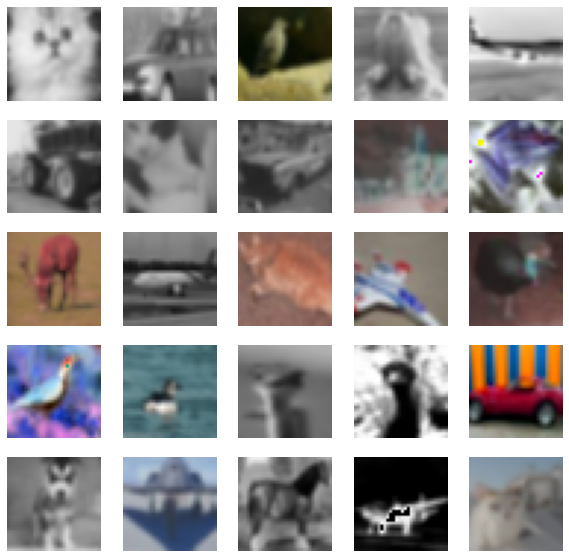

In [6]:
# Visualize a few augmented images.
sample_images_one = next(iter(ssl_ds_one))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_one[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

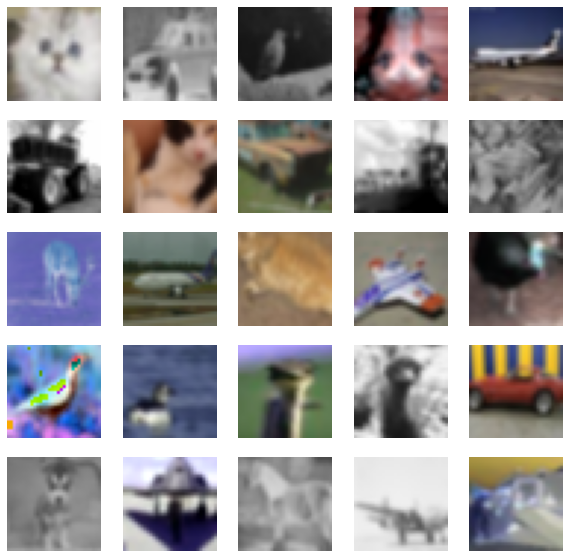

In [7]:
# Ensure that the different versions of the dataset actually contain
# identical images.
sample_images_two = next(iter(ssl_ds_two))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sample_images_two[n].numpy().astype("int"))
    plt.axis("off")
plt.show()

## Barlow Twins' Loss

The main crux of Barlow Twins lies in the way the authors formulate the loss function. Here's the overall pseudocode for Barlow Twins (taken from the [original paper](https://arxiv.org/abs/2103.03230)): 



![](https://i.ibb.co/bJLRjzx/image.png)

**References**:
* https://github.com/facebookresearch/barlowtwins/

In [8]:
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n-1, n+1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])


def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / tf.math.reduce_std(z, axis=0)
    return z_norm


def compute_loss(z_a, z_b, lambd):
    # Get batch size and representation dimension.
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss    

## Wrap training logic inside a `tf.keras.Model` class

In [9]:
class BarlowTwins(tf.keras.Model):
    def __init__(self, encoder, lambd=5e-3):
        super(BarlowTwins, self).__init__()
        self.encoder = encoder
        self.lambd = lambd
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        # Unpack the data.
        ds_one, ds_two = data

        # Forward pass through the encoder and predictor.
        with tf.GradientTape() as tape:
            z_a, z_b = self.encoder(ds_one, training=True), self.encoder(ds_two, training=True)
            loss = compute_loss(z_a, z_b, self.lambd) 

        # Compute gradients and update the parameters.
        gradients = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))

        # Monitor loss.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

## Set up learning rate schedule, optimizer, and the network

In [10]:
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=1e-3,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

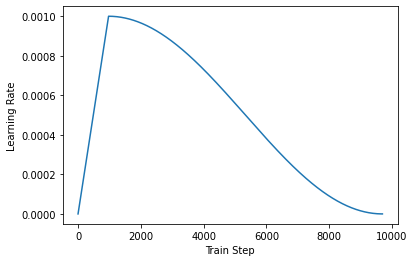

In [11]:
# Visualize the LR schedule
plt.plot(lr_decayed_fn(tf.range(EPOCHS*STEPS_PER_EPOCH, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [12]:
resnet_enc = resnet20.get_network(hidden_dim=PROJECT_DIM, use_pred=False, 
                                          return_before_head=False)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)

## Training using Barlow Twins

In [13]:
barlow_twins = BarlowTwins(resnet_enc)
barlow_twins.compile(optimizer=optimizer)
history = barlow_twins.fit(ssl_ds, epochs=EPOCHS)

Epoch 1/100
98/98 [==============================] - 34s 135ms/step - loss: 1054.2041
Epoch 2/100
98/98 [==============================] - 13s 130ms/step - loss: 555.9126
Epoch 3/100
98/98 [==============================] - 13s 129ms/step - loss: 385.5475
Epoch 4/100
98/98 [==============================] - 13s 129ms/step - loss: 308.3120
Epoch 5/100
98/98 [==============================] - 13s 129ms/step - loss: 266.4960
Epoch 6/100
98/98 [==============================] - 13s 129ms/step - loss: 238.7286
Epoch 7/100
98/98 [==============================] - 13s 130ms/step - loss: 216.3723
Epoch 8/100
98/98 [==============================] - 13s 128ms/step - loss: 202.5424
Epoch 9/100
98/98 [==============================] - 13s 127ms/step - loss: 192.4938
Epoch 10/100
98/98 [==============================] - 13s 128ms/step - loss: 183.0860
Epoch 11/100
98/98 [==============================] - 13s 128ms/step - loss: 172.8183
Epoch 12/100
98/98 [==============================] - 13s 128m

**Total training time**: ~23 minutes on a Tesla V100.

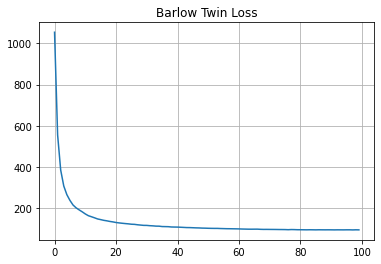

In [14]:
# Visualize the training progress of the model.
plt.plot(history.history["loss"])
plt.grid()
plt.title("Barlow Twin Loss")
plt.show()

In [15]:
# Save the model.
barlow_twins.encoder.save("barlow_twins")

INFO:tensorflow:Assets written to: barlow_twins/assets


## Linear Evaluation

**References**:
* https://keras.io/examples/vision/simsiam/

In [19]:
# We first create labeled `Dataset` objects.
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Then we shuffle, batch, and prefetch this dataset for performance. We
# also apply random resized crops as an augmentation but only to the
# training set.
train_ds = (
    train_ds.shuffle(1024)
    .map(lambda x, y: (flip_random_crop(x), y), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Extract the backbone ResNet20.
backbone = tf.keras.Model(
    barlow_twins.encoder.input, barlow_twins.encoder.layers[-8].output
)

# We then create our linear classifier and train it.
backbone.trainable = False
inputs = tf.keras.layers.Input((CROP_TO, CROP_TO, 3))
x = backbone(inputs, training=False)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
linear_model = tf.keras.Model(inputs, outputs, name="linear_model")

In [20]:
# Cosine decay for linear evaluation.
cosine_decayed_lr = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.3, decay_steps=EPOCHS * STEPS_PER_EPOCH
)

In [21]:
# Compile model and start training.
linear_model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer=tf.keras.optimizers.SGD(cosine_decayed_lr, momentum=0.9),
)
history = linear_model.fit(
    train_ds, validation_data=test_ds, epochs=10
)
_, test_acc = linear_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
98/98 [==============================] - 5s 36ms/step - loss: 3.9090 - accuracy: 0.4485 - val_loss: 2.6720 - val_accuracy: 0.5653
Epoch 2/10
98/98 [==============================] - 3s 32ms/step - loss: 2.5266 - accuracy: 0.6035 - val_loss: 2.5006 - val_accuracy: 0.6204
Epoch 3/10
98/98 [==============================] - 3s 28ms/step - loss: 2.4924 - accuracy: 0.6170 - val_loss: 2.4329 - val_accuracy: 0.6234
Epoch 4/10
98/98 [==============================] - 3s 28ms/step - loss: 2.4021 - accuracy: 0.6322 - val_loss: 2.7209 - val_accuracy: 0.5699
Epoch 5/10
98/98 [==============================] - 3s 29ms/step - loss: 2.4041 - accuracy: 0.6352 - val_loss: 2.6843 - val_accuracy: 0.5812
Epoch 6/10
98/98 [==============================] - 3s 29ms/step - loss: 2.3987 - accuracy: 0.6331 - val_loss: 2.6955 - val_accuracy: 0.5667
Epoch 7/10
98/98 [==============================] - 3s 29ms/step - loss: 2.3894 - accuracy: 0.6387 - val_loss: 2.6482 - val_accuracy: 0.5779
Epoch 8/10
98

**Acknowledgements**:

Thanks to Stéphane Deny (one of the authors of the paper) for helping me catch a pesky bug. 